# Convolutional networks for TF ChIP-seq data

This notebook has a simple one layer convolutional network similar to the one proposed in the "DeepBind" paper.

In [1]:
import csv
import torch
from sklearn import metrics
from sklearn.model_selection import train_test_split

import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os 
import warnings
#warnings.filterwarnings("ignore")

## Data

In [2]:
# datasets can be obtained e.g. from:
# https://github.com/MedChaabane/deepRAM/tree/master/datasets/ChIP-seq

# convert sequence to a one-hot encoding
# and pad with a uniform distribution
def seqtopad(sequence, motif_len):
    rows=len(sequence)+2*motif_len-2
    S=np.empty([rows,4])
    base=['A', 'C', 'G', 'T']
    for i in range(rows):
        for j in range(4):
            if (i-motif_len+1<len(sequence) and sequence[i-motif_len+1]=='N' 
                or i<motif_len-1 or i>len(sequence)+motif_len-2):
                S[i,j]=np.float32(0.25)
            elif sequence[i-motif_len+1]==base[j]:
                S[i,j]=np.float32(1)
            else:
                S[i,j]=np.float32(0)
    return np.transpose(S)

def load_file(path, motif_len=24):
    dataset=[]
    sequences=[]
    with open(path, 'rt') as file_handle:
        # skip the header:
        next(file_handle)
        reader = csv.reader(file_handle, delimiter='\t')
        for row in reader:
            sequence = row[2]
            label = int(row[3])
            dataset.append([seqtopad(sequence, motif_len),[label]])
            sequences.append(sequence)
    return dataset  

class chipseq_dataset(Dataset):
    def __init__(self, xy):
        self.x_data=np.asarray([el[0] for el in xy],dtype=np.float32)
        self.y_data =np.asarray([el[1] for el in xy ],dtype=np.float32)
        self.x_data = torch.from_numpy(self.x_data)
        self.y_data = torch.from_numpy(self.y_data)
        self.length=len(self.x_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

In [3]:
dataset=load_file("SRF_H1-hESC_SRF_HudsonAlpha_B.seq")
train_data, valid_data = train_test_split(dataset, test_size=0.25)

In [4]:
len(train_data),len(valid_data)

(750, 250)

In [5]:
train_dataset=chipseq_dataset(train_data)
valid_dataset=chipseq_dataset(valid_data)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,shuffle=True)

## The model

Below is an implementation of a simple one-layer CNN, as described in the Deep-Bind paper.

In [6]:
class DeepBind(nn.Module):
    def __init__(self, num_motif, motif_len,
                 sigma_conv, sigma_w):
      
        super(DeepBind, self).__init__()
        # width parameter for initialization of convolutional filters
        self.sigma_conv=sigma_conv
        # width parameter for initialization of fully connected layer
        self.sigma_w=sigma_w
        # number of input channels
        self.input_channels=4
        # activation function
        self.activation = nn.ReLU()
        self.conv_weights=torch.empty(num_motif,
                                      self.input_channels, 
                                      motif_len,dtype=torch.float).to(device)
        self.conv_bias=torch.empty(num_motif, dtype=torch.float).to(device)
        self.FC_size=num_motif
        torch.nn.init.normal_(self.conv_weights, std=sigma_conv)
        torch.nn.init.normal_(self.conv_bias)        
        self.conv_weights.requires_grad=True
        self.conv_bias.requires_grad=True
        
        self.w=torch.empty(self.FC_size,1, dtype=torch.float).to(device)
        self.b=torch.empty(1, dtype=torch.float).to(device)
        torch.nn.init.normal_(self.w,mean=0,
                              std=self.sigma_w)
        torch.nn.init.normal_(self.b,mean=0,
                              std=self.sigma_w)
        self.w.requires_grad=True
        self.b.requires_grad=True
                
    def get_weights(self):
        return [self.conv_weights, self.conv_bias, model.w, model.b]
        
    def forward(self, x):
        # 1d convolution:
        x=nn.functional.conv1d(x, self.conv_weights, bias=self.conv_bias, 
                   stride=1, padding=0)
        # activation
        x=self.activation(x)
        # max pooling
        x,_ = torch.max(x, dim=2)
        # fully connected layer
        x=x@self.w + self.b
        return torch.sigmoid(x)
    

In [7]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 :
        print(f"training loss: {total_loss/num_batches:>7f}")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn, epoch):
    # set the model to evaluation mode 
    model.eval()
    # size of dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            pred = np.heaviside(y_pred.detach().numpy().reshape(len(y_pred))-0.5,0)
            correct += (pred == y.detach().numpy().reshape(len(y))).sum()
    test_loss /= num_batches
    correct /= size
    if epoch%10 == 0 :
        print(f"Test Accuracy: {correct:>8f}\nAvg test loss: {test_loss:>8f} \n")
    return test_loss


In [8]:
device = 'cpu'
model = DeepBind(8,12,1e-06,0.001).to(device)

optimizer = torch.optim.SGD(model.get_weights(),
                            lr=0.01,momentum=0.9,nesterov=True, weight_decay=1e-06);

#optimizer = torch.optim.Adam(model.get_weights(), lr=0.01)

### Exercise

Try varying the optimizer and number of training epochs and see the effect on accuracy.

In [9]:
epochs = 200
loss_fn = nn.BCELoss()

train_loss = []
validation_loss = []
for t in range(epochs):
    if t % 10 == 0 :
        print(f"Epoch {t}\n-------------------------------")
    loss = train_epoch(train_loader, model, loss_fn, optimizer, t)
    train_loss.append(loss)
    loss = validation(valid_loader, model, loss_fn, t)
    validation_loss.append(loss)
print("Done!")


Epoch 0
-------------------------------
training loss: 0.693291
Test Accuracy: 0.500000
Avg test loss: 0.693146 

Epoch 10
-------------------------------
training loss: 0.693299
Test Accuracy: 0.500000
Avg test loss: 0.693143 

Epoch 20
-------------------------------
training loss: 0.693420
Test Accuracy: 0.500000
Avg test loss: 0.693167 

Epoch 30
-------------------------------
training loss: 0.693034
Test Accuracy: 0.500000
Avg test loss: 0.692901 

Epoch 40
-------------------------------
training loss: 0.690353
Test Accuracy: 0.616000
Avg test loss: 0.690120 

Epoch 50
-------------------------------
training loss: 0.666961
Test Accuracy: 0.544000
Avg test loss: 0.667833 

Epoch 60
-------------------------------
training loss: 0.578435
Test Accuracy: 0.748000
Avg test loss: 0.595219 

Epoch 70
-------------------------------
training loss: 0.484619
Test Accuracy: 0.800000
Avg test loss: 0.510773 

Epoch 80
-------------------------------
training loss: 0.396581
Test Accuracy: 0

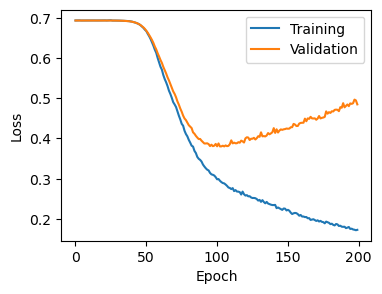

In [10]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4,3))
plt.plot(train_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0)
plt.legend();

In [11]:
with torch.no_grad():
    model.eval()
    pred_list = []
    labels_list = []
    for i, (data, target) in enumerate(valid_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        pred=output.cpu().detach().numpy().reshape(output.shape[0])
        labels=target.cpu().numpy().reshape(output.shape[0])
        pred_list.append(pred)
        labels_list.append(labels)
    labels = np.concatenate(labels_list)
    predictions = np.concatenate(pred_list)
    auc = metrics.roc_auc_score(labels, predictions)
    print('AUC on validation data ', auc)


AUC on validation data  0.8966079999999998


Next, we'll take a look at the convolutional weights:

In [12]:
len(model.conv_weights), model.conv_weights[1].shape

(8, torch.Size([4, 12]))

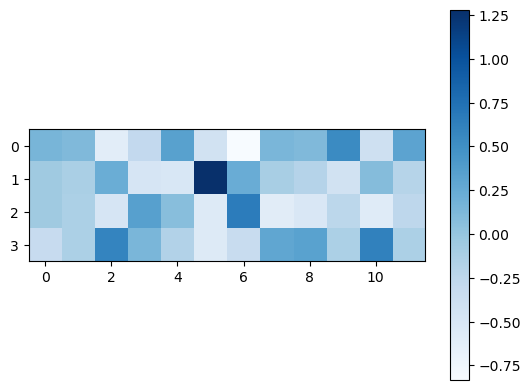

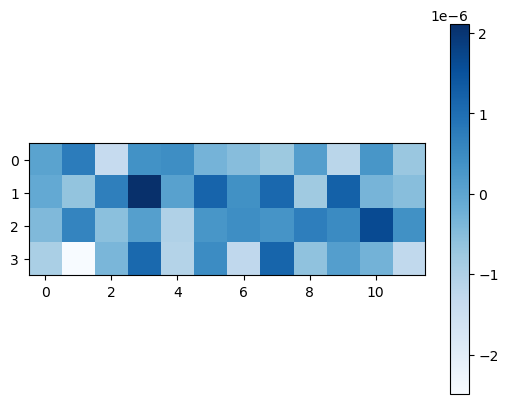

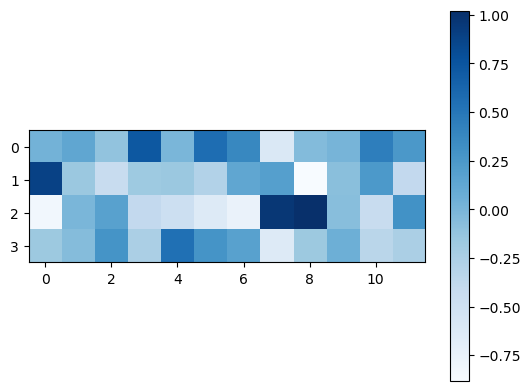

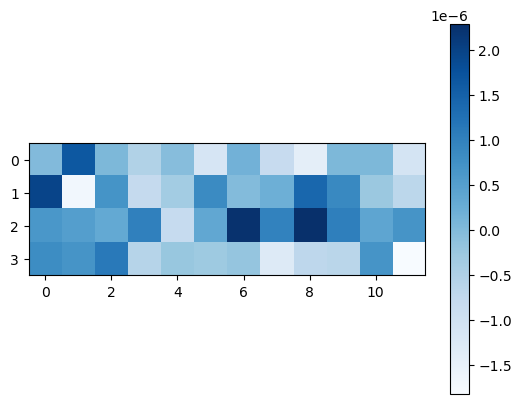

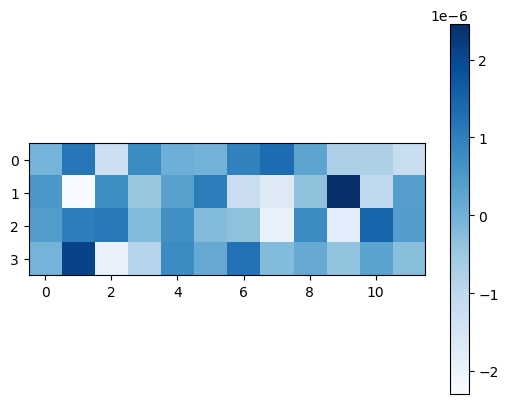

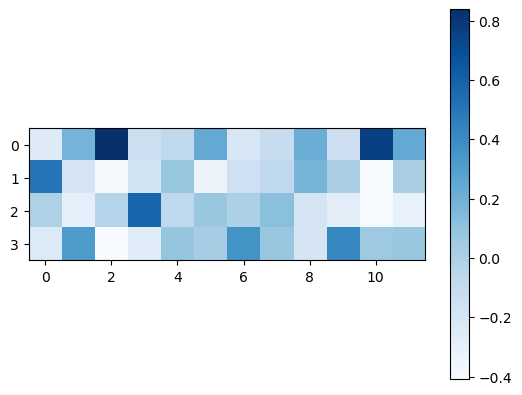

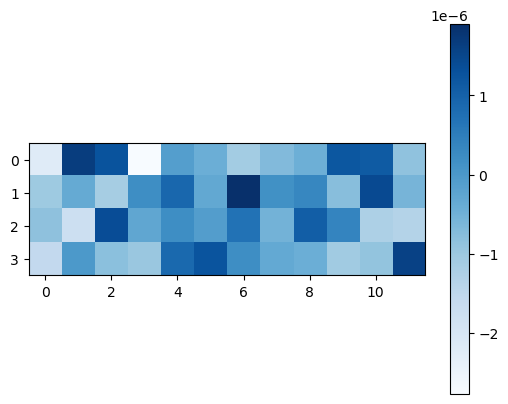

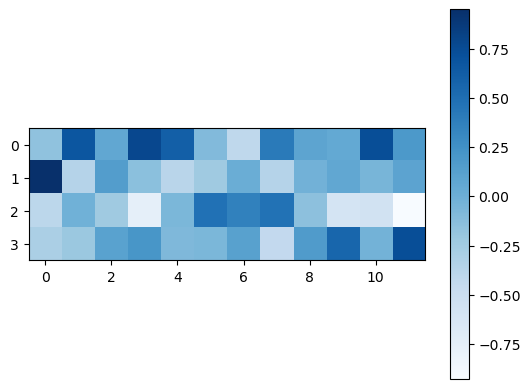

In [13]:
import matplotlib.pyplot as plt

# convert the convolutional filters to a numpy array:
weights = model.conv_weights.detach().numpy()

# plot the convolutional filters:
for filter in range(len(weights)) :
    fig = plt.figure()
    plt.imshow(weights[filter],cmap="Blues")
    plt.colorbar()